In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler


In [2]:
keep_data = pd.read_csv(r"C:\Users\mjcanudo\Documents\Nova\ML\Project2\datasets\keep_data.csv", index_col='Cust_ID')
all_data = pd.read_csv(r"C:\Users\mjcanudo\Documents\Nova\ML\Project2\datasets\all_data.csv", index_col='Cust_ID')

In [3]:
from sklearn.svm import SVC

In [4]:
X_keep_svm = keep_data.drop(columns="Buy_product").copy()
y_keep_svm = keep_data["Buy_product"].copy()

In [5]:
X_all_svm = all_data.drop(columns="Buy_product").copy()
y_all_svm = all_data["Buy_product"].copy()

In [6]:
scaler_for_svm = MinMaxScaler()
scaled_keep = scaler_for_svm.fit_transform(X_keep_svm)
scaled_all = scaler_for_svm.fit_transform(X_all_svm)

In [7]:
keep_data_X_scaled = pd.DataFrame(scaled_keep, columns=X_keep_svm.columns, index=X_keep_svm.index)
all_data_X_scaled = pd.DataFrame(scaled_all, columns=X_all_svm.columns, index=X_all_svm.index)

SVM has several methods (kernels) which can be used. Default is RBF. According to Aurélien Géron in Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, the linear kernel is simple and provides very good results when the data is linearly separable. For this reason, we first decided to plot the data to check if it was linearly separable, in which case we could employ SVC with kernel='linear'

In [8]:
from sklearn.decomposition import PCA


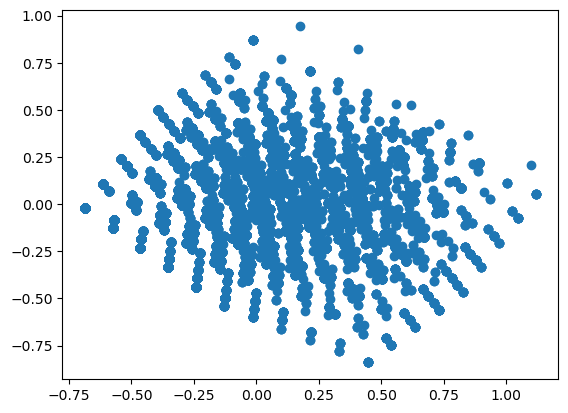

In [9]:
pca_model = PCA(n_components=2)
keep_data_reduced = pca_model.fit_transform(keep_data_X_scaled)
plt.scatter(keep_data_reduced[:,0], keep_data_reduced[:,1])

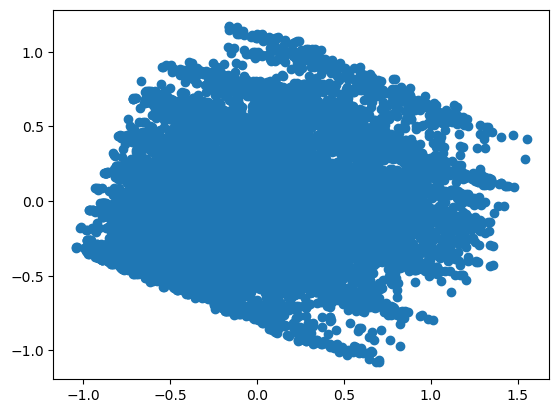

In [10]:
pca_model = PCA(n_components=2)
all_data_reduced = pca_model.fit_transform(all_data_X_scaled)
plt.scatter(all_data_reduced[:,0], all_data_reduced[:,1])

Data does not look nearly close to being linearly separable, so we decide to go with the RBF kernel, which is appropriate for non-linear data.

Documentation:

"When training an SVM with the Radial Basis Function (RBF) kernel, two parameters must be considered: C and gamma. The parameter C, common to all SVM kernels, trades off misclassification of training examples against simplicity of the decision surface. A low C makes the decision surface smooth, while a high C aims at classifying all training examples correctly. gamma defines how much influence a single training example has. The larger gamma is, the closer other examples must be to be affected.

Proper choice of C and gamma is critical to the SVM’s performance. One is advised to use GridSearchCV with C and gamma spaced exponentially far apart to choose good values."

For this reason, we'll run GridSearchCV before even trying the model with default values, to make sure we have good hyperparameters when testing

In [11]:
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [12]:
param_grid_svm_rbf = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [7, 5, 3, 1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}

grid_search = GridSearchCV(SVC(),
                        param_grid_svm_rbf,
                        scoring = 'f1',
                        return_train_score = True,
                        cv = 5,
                        verbose=1)

IMPORTANT

These two cells are commented out because the Grid Search takes one hour to run. The results for each are in the comments at the bottom of each cell.

In [13]:
## IMPORTANT ##
# These two cells are commented out because they take one hour to run. The results for each are in the comments at the bottom.

#grid_search.fit(keep_data_X_scaled, y_keep_svm)

# Print the best hyperparameters and corresponding score
#print("Best Hyperparameters: ", grid_search.best_params_)
#print("Best Score: ", grid_search.best_score_)

# Result: 
# Fitting 5 folds for each of 56 candidates, totalling 280 fits
# Best Hyperparameters:  {'C': 1000, 'gamma': 5, 'kernel': 'rbf'}
# Best Score:  0.8941311992717632

In [14]:
#grid_search.fit(all_data_X_scaled, y_all_svm)

# Print the best hyperparameters and corresponding score
#print("Best Hyperparameters: ", grid_search.best_params_)
#print("Best Score: ", grid_search.best_score_)

# Result: 
# Fitting 5 folds for each of 56 candidates, totalling 280 fits
# Best Hyperparameters:  {'C': 1, 'gamma': 5, 'kernel': 'rbf'}
# Best Score:  0.9148676589466327

Interesting to note that the keep_data allows for a much higher C value, meaning that it is more resistant to overfitting (most likely because of the feature selection we did) and is trying to classify all points correctly, but it has a lower f1 score. 

The all_data allows for a much lower C value, meaning a higher chance of missclassification, but then has a higher f1 score.

In [12]:
def select_best_models(data, model):
    skf = StratifiedKFold(n_splits = 5, random_state = 99, shuffle = True)
    X = data.drop('Buy_product', axis = 1)
    y = data['Buy_product'].copy()

    score_train, score_val = [],[]

    # perform the cross-validation
    for train_index, val_index in skf.split(X,y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Scale the data
        scaler = MinMaxScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        X_val = scaler.transform(X_val)

        # Apply model
        model.fit(X_train, y_train)
        predictions_train = model.predict(X_train)
        predictions_val = model.predict(X_val)
        score_train.append(f1_score(y_train, predictions_train))
        score_val.append(f1_score(y_val, predictions_val))

    avg_train = round(np.mean(score_train),3)
    avg_val = round(np.mean(score_val),3)
    std_train = round(np.std(score_train),2)
    std_val = round(np.std(score_val),2)

    return avg_train, std_train, avg_val, std_val

In [13]:
def show_results(df, data, *args):
    count = 0
    # for each instance of model passed as argument
    for arg in args:
        avg_train, std_train, avg_val, std_val = select_best_models(data, arg)
        # store the results in the right row
        df.iloc[count] = str(avg_train) + '+/-' + str(std_train), str(avg_val) + '+/-' + str(std_val)
        count+=1
    return df

Testing both keep_data and all_data with the parameters from the GridSearchCV

In [17]:
rbf_model_tunned_keep = SVC(kernel='rbf', C=1000, gamma=5)
rbf_model_tunned_all = SVC(kernel='rbf', C=1, gamma=5)

In [18]:
df_all = pd.DataFrame(columns = ['Train','Validation'], index = ['RBF'])

show_results(df_all, keep_data, rbf_model_tunned_keep)

In [ ]:
df_all = pd.DataFrame(columns = ['Train','Validation'], index = ['RBF'])

show_results(df_all, all_data, rbf_model_tunned_all)

,Train,Validation
RBF,0.949+/-0.0,0.914+/-0.0


while keep_data has a pretty good result, all_data shows some overfitting:


Train 0.949 

Validation 0.914


The C parameter in SVC has the most impact, so we try to gradually decreasing it for better results.

In [ ]:
# after several iterations gradually decreasing the C value, we found that 0.3 provided the best score and balance between f1 score and minimal difference between train and validation scores

rbf_model_tunned_all = SVC(kernel='rbf', C=0.3, gamma=5)

df_all = pd.DataFrame(columns = ['Train','Validation'], index = ['RBF'])

show_results(df_all, all_data, rbf_model_tunned_all)

,Train,Validation
RBF,0.928+/-0.0,0.91+/-0.0


In [14]:
GammaValues = np.logspace(-3, 3, 7)
GammaValues

array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])

In [13]:
param_grid_svm_rbf = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [7, 5, 3, 1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['poly']}

grid_search = GridSearchCV(SVC(),
                        param_grid_svm_rbf,
                        scoring = 'f1',
                        return_train_score = True,
                        cv = 5,
                        verbose=1)

grid_search.fit(all_data_X_scaled, y_all_svm)

# Print the best hyperparameters and corresponding score
print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)


Fitting 5 folds for each of 40 candidates, totalling 200 fits


In [ ]:
param_grid_svm_rbf_sigmoid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [7, 5, 3, 1, 0.1, 0.01], 
              'kernel': ['rbf', 'sigmoid']}

param_grid_svm_poly = {'C': [0.1, 1, 10, 100, 1000],
                        'gamma': [7, 5, 3, 1, 0.1, 0.01],
                        'degree' : [1,2,3,4,5],
                        'kernel': ['poly']}

multi_kernel_search = [param_grid_svm_rbf_sigmoid, param_grid_svm_poly]


grid_search = GridSearchCV(SVC(),
                        multi_kernel_search,
                        scoring = 'f1',
                        return_train_score = True,
                        cv = 5,
                        verbose=1)

grid_search.fit(all_data_X_scaled, y_all_svm)

# Print the best hyperparameters and corresponding score
print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)